<a href="https://colab.research.google.com/github/Adithya707/AML/blob/main/Copy_of_3_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 
     |████████████████████████████████| 5.8 MB 59.1 MB/s 
     |████████████████████████████████| 438 kB 75.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/BTC-USD.csv"
# csv_path = "https://raw.githubusercontent.com/curiousily/Deep-Learning-For-Hackers/master/data/3.stock-prediction/AAPL.csv"

In [ ]:
df = pd.read_csv(csv_path, parse_dates=['Date'])

In [ ]:
df = df.sort_values('Date')

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.04951,0.04951,0.04951,0.04951,0.04951,0
1,2010-07-17,0.04951,0.08585,0.05941,0.08584,0.08584,5
2,2010-07-18,0.08584,0.09307,0.07723,0.08080,0.08080,49
3,2010-07-19,0.08080,0.08181,0.07426,0.07474,0.07474,20
4,2010-07-20,0.07474,0.07921,0.06634,0.07921,0.07921,42


In [ ]:
df.shape

(3201, 7)

Text(0, 0.5, 'Close Price (USD)')

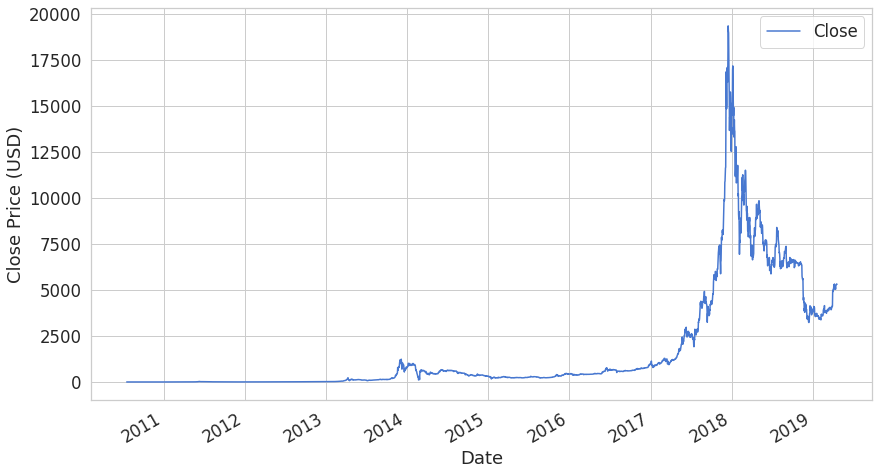

In [ ]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")

# Normalization

In [ ]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
scaled_close.shape

(3201, 1)

In [ ]:
np.isnan(scaled_close).any()

False

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [ ]:
scaled_close = scaled_close.reshape(-1, 1)

In [ ]:
np.isnan(scaled_close).any()

False

# Preprocessing

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

(2945, 99, 1)

In [ ]:
X_test.shape
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
#from keras.optimizers import SGD

In [ ]:
!pip install tensorflow
!pip install keras-utils
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
#from keras.utils import Sequence
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Model

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
42/42 [==============================] - 11s 64ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 2/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0086 - val_loss: 0.0424
Epoch 3/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0210 - val_loss: 0.0181
Epoch 4/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 5/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 6/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0136 - val_loss: 0.0821
Epoch 7/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0150 - val_loss: 0.0209
Epoch 8/50
42/42 [==============================] - 2s 40ms/step - loss: 0.0229 - val_loss: 0.0705
Epoch 9/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0103 - val_loss: 0.0284
Epoch 10/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0191 - val_loss: 0.0431
Epoch 11

In [ ]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 32ms/step - loss: 0.0060


0.006048079580068588

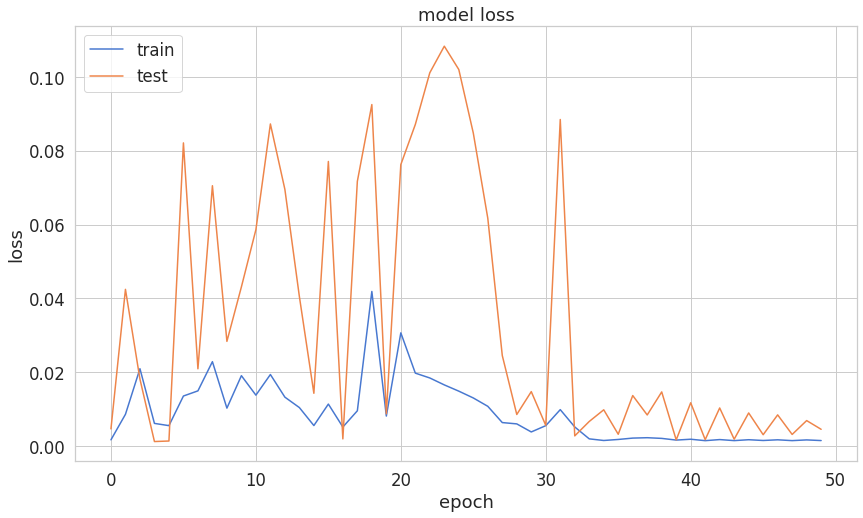

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

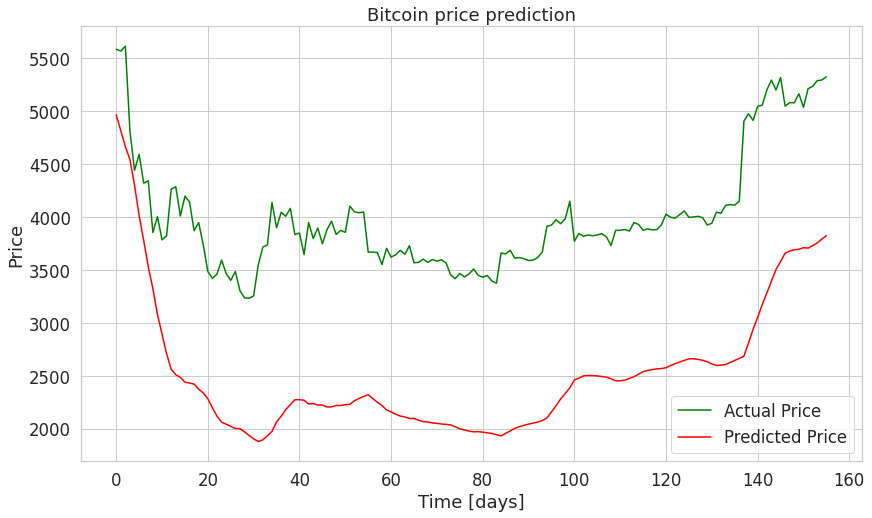

In [ ]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();